In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset

In [196]:
report_data = pd.read_csv('report_data.csv', delimiter=';')

# General preprocessing

In [197]:
df = report_data.copy()
df = df.replace('Нет ответа', np.nan)

In [199]:
sns.set(rc={'figure.figsize':(12,12)})

def clean_unnecessary(df):
    for column in df.columns:
        categories = df[column].value_counts()
        categories = categories.where(lambda x: x < 20).dropna().index.unique()
        df[column] = df[column].astype('category').cat.remove_categories(categories)
    return df


def visualize(df):
    # visualize sex distirbution
    fig, ax = plt.subplots(3, 1)
    sns.countplot(x=df[df.columns[3]], ax=ax[0])

    # visualize age distribution
    sns.countplot(x=df[df.columns[4]], ax=ax[1])

    # visualize education distribution
    sns.countplot(x=df[df.columns[5]], ax=ax[2])
    fig.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

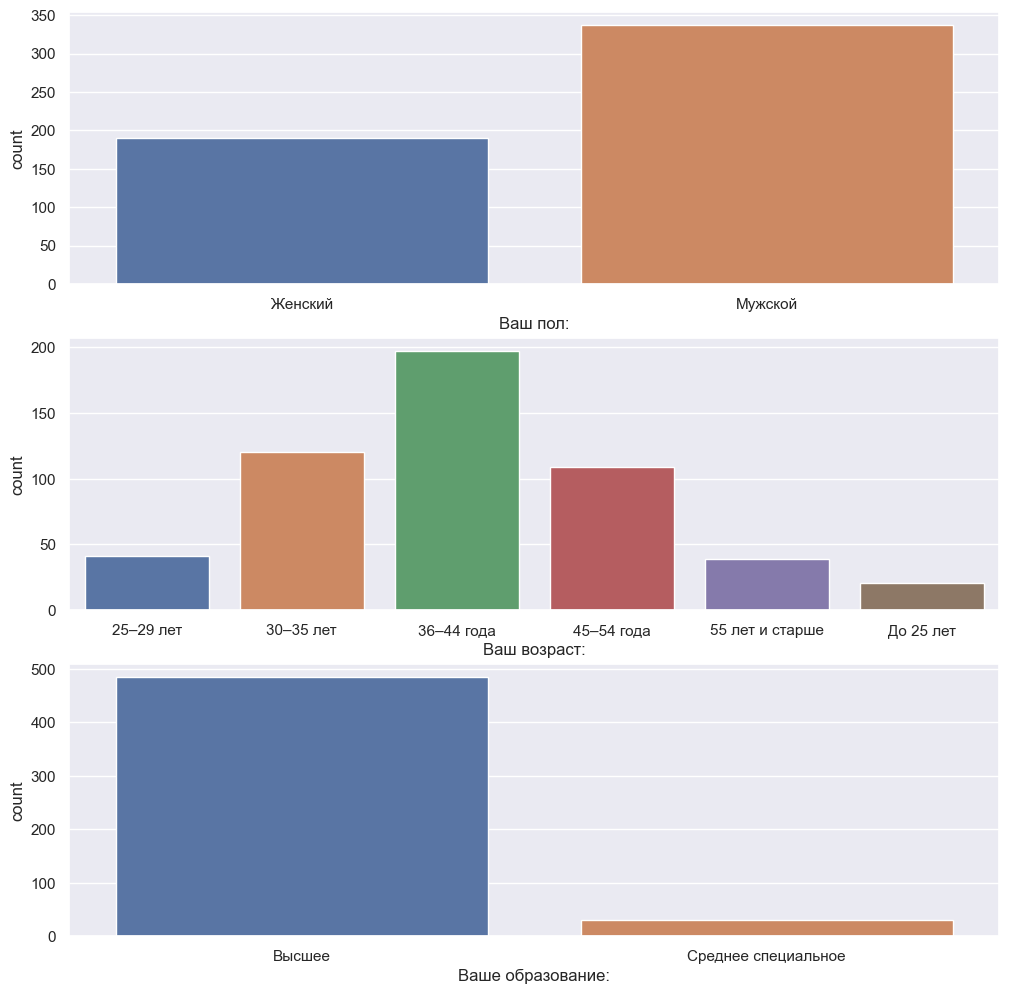

In [200]:
df_filt = df[df[df.columns[6]] == 'Электроэнергетический']
visualize(clean_unnecessary(df_filt))

# Preprocessing for HYPOTHESIS #1 (not done)

In [ ]:
hypothesis_columns_2 = [df.columns[x] for x in [*\INSERT HERE*/]]
hypothesis_columns_2.extend([*\INSERT HERE*/])
df_1 = df.copy()[hypothesis_columns_2]

df_1 = df_1.dropna()
buffer_column = df_1[df_1.columns[-1]]
df_1 = clean_unnecessary(df_1.drop(df_1.columns[-1], axis=1))
df_1[buffer_column.name] = buffer_column
df_2 = df_1.dropna()

df_1 = df.copy()

# Preprocessing for HYPOTHESIS 2

In [201]:
# 2nd hypothesis
q1 = 'Сколько времени на обучение в среднем в неделю вы готовы выделять?'
q2 = 'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?'
q3 = 'Представьте, что у вас есть возможность всегда выбирать, в каком формате проходить обучение в РЕКОРД mobile.'

hypothesis_columns_2 = [df.columns[x] for x in [3, 4, 5, 6, 8, 9]]
hypothesis_columns_2.extend([q1,q2,q3])
df_2 = df.copy()[hypothesis_columns_2]

df_2 = df_2.copy().dropna()
buffer_column = df_2[df_2.columns[-1]]
df_2 = clean_unnecessary(df_2.drop(df_2.columns[-1], axis=1))
df_2[buffer_column.name] = buffer_column
df_2 = df_2.dropna()

In [203]:
# OneHotEncode (dummify) all categorical features and Y columns

df_2_dummified = pd.get_dummies(df_2, columns=df_2.columns[:-1])
ans3 = df_2_dummified[df_2_dummified.columns[0]]
df_2_dummified = df_2_dummified.drop(df_2_dummified.columns[0], axis=1)

In [204]:
# Define features

X = df_2_dummified[df_2_dummified.columns[:-10]]

In [257]:
# Define list of Y columns

Y = df_2_dummified[df_2_dummified.columns[-10:]]
#Y[ans3.name] = ans3
Y.columns

Index(['Сколько времени на обучение в среднем в неделю вы готовы выделять?_Более 2-х часов',
       'Сколько времени на обучение в среднем в неделю вы готовы выделять?_До 30 минут',
       'Сколько времени на обучение в среднем в неделю вы готовы выделять?_Нет возможности выделять время каждую неделю',
       'Сколько времени на обучение в среднем в неделю вы готовы выделять?_От 1 часа до 2-х часов',
       'Сколько времени на обучение в среднем в неделю вы готовы выделять?_От 30 минут до 1 часа',
       'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?_В обеденный перерыв',
       'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?_В рабочее время',
       'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?_Мне не назначают обучение',
       'Когда чаще всего вы проходите обучение, назначенное HR/в системе РЕКОРД?_По вечерам/на выходных/в отпуске',
       'Когда чаще всего вы проходите обучение, назначенное HR/в систе

# Define function to calculate feature importance

In [260]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap


def get_feature_importances_from_column(X, Y, column, plot_shap):
    y = Y[Y.columns[column]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model = XGBRegressor(gamma=1)
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_    
    if plot_shap == True:
        fig, ax = plt.subplots()
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
        shap.summary_plot(shap_values, X_train)
        plt.show()
    else:
        sns.barplot(x=feature_importances, y=X.columns)
        plt.title(y.name)
        plt.show()
    return feature_importances
    

# Calculate and visualize feature importances for HYPHOTHESIS #1 (not done)

# Calculate and visualize feature importances for HYPHOTHESIS #2

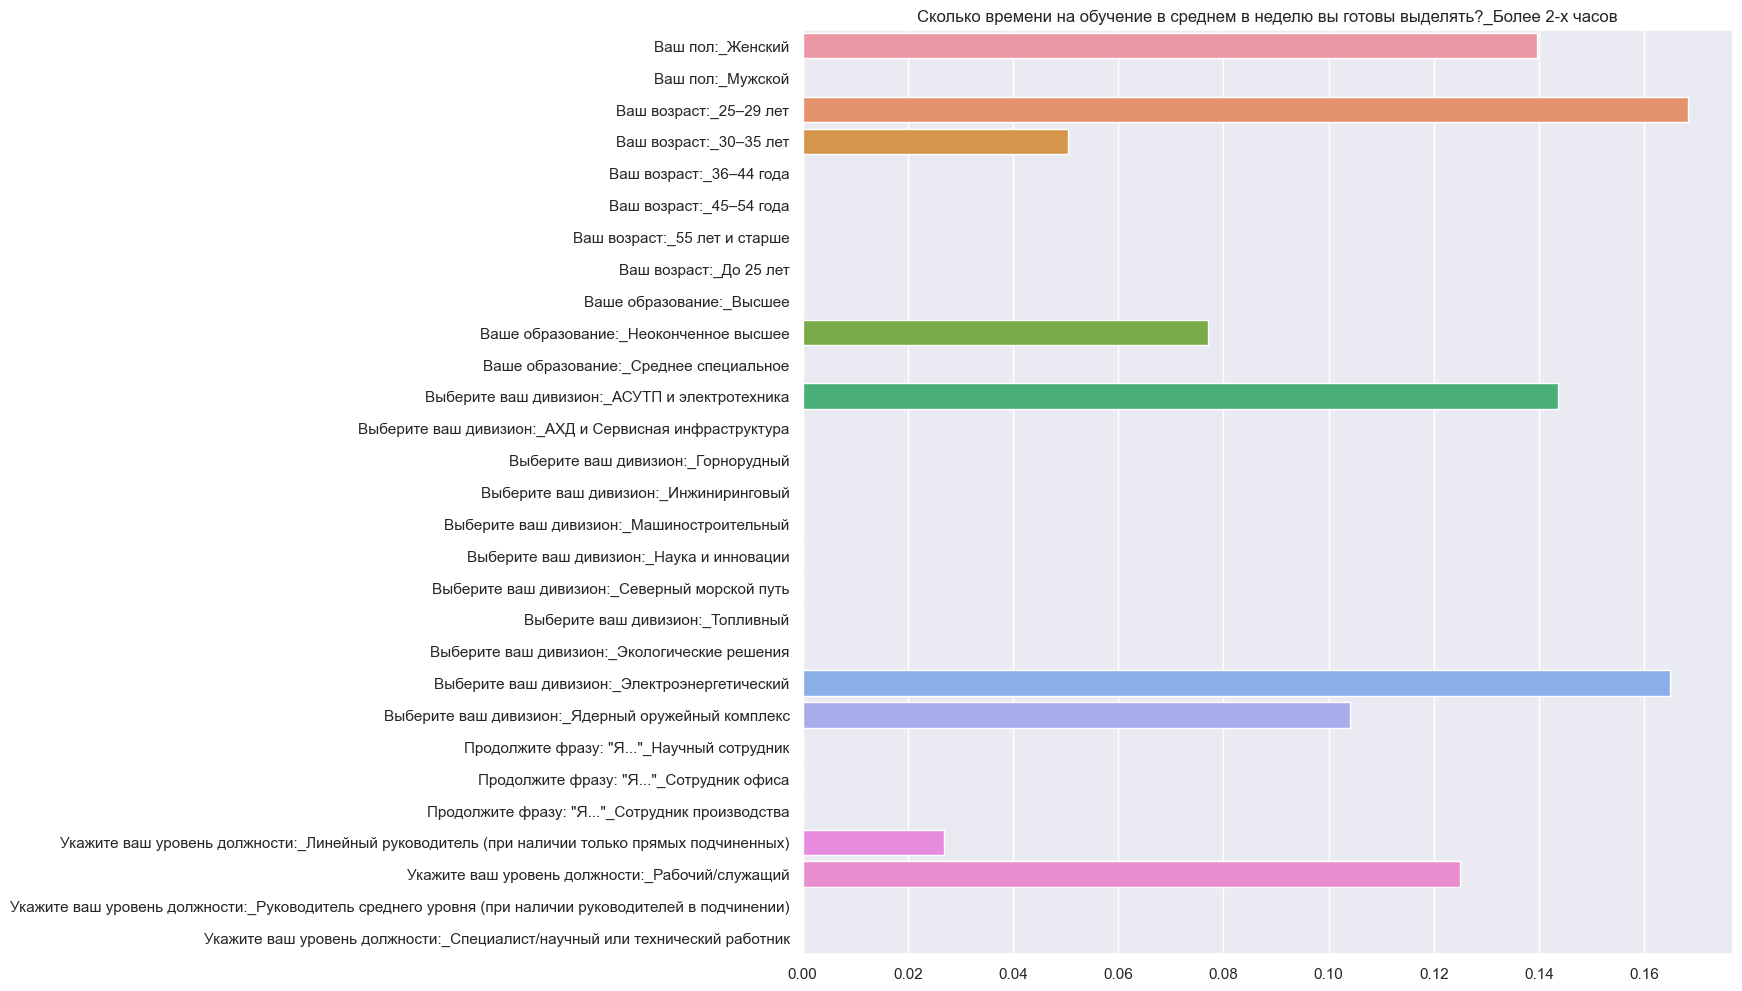

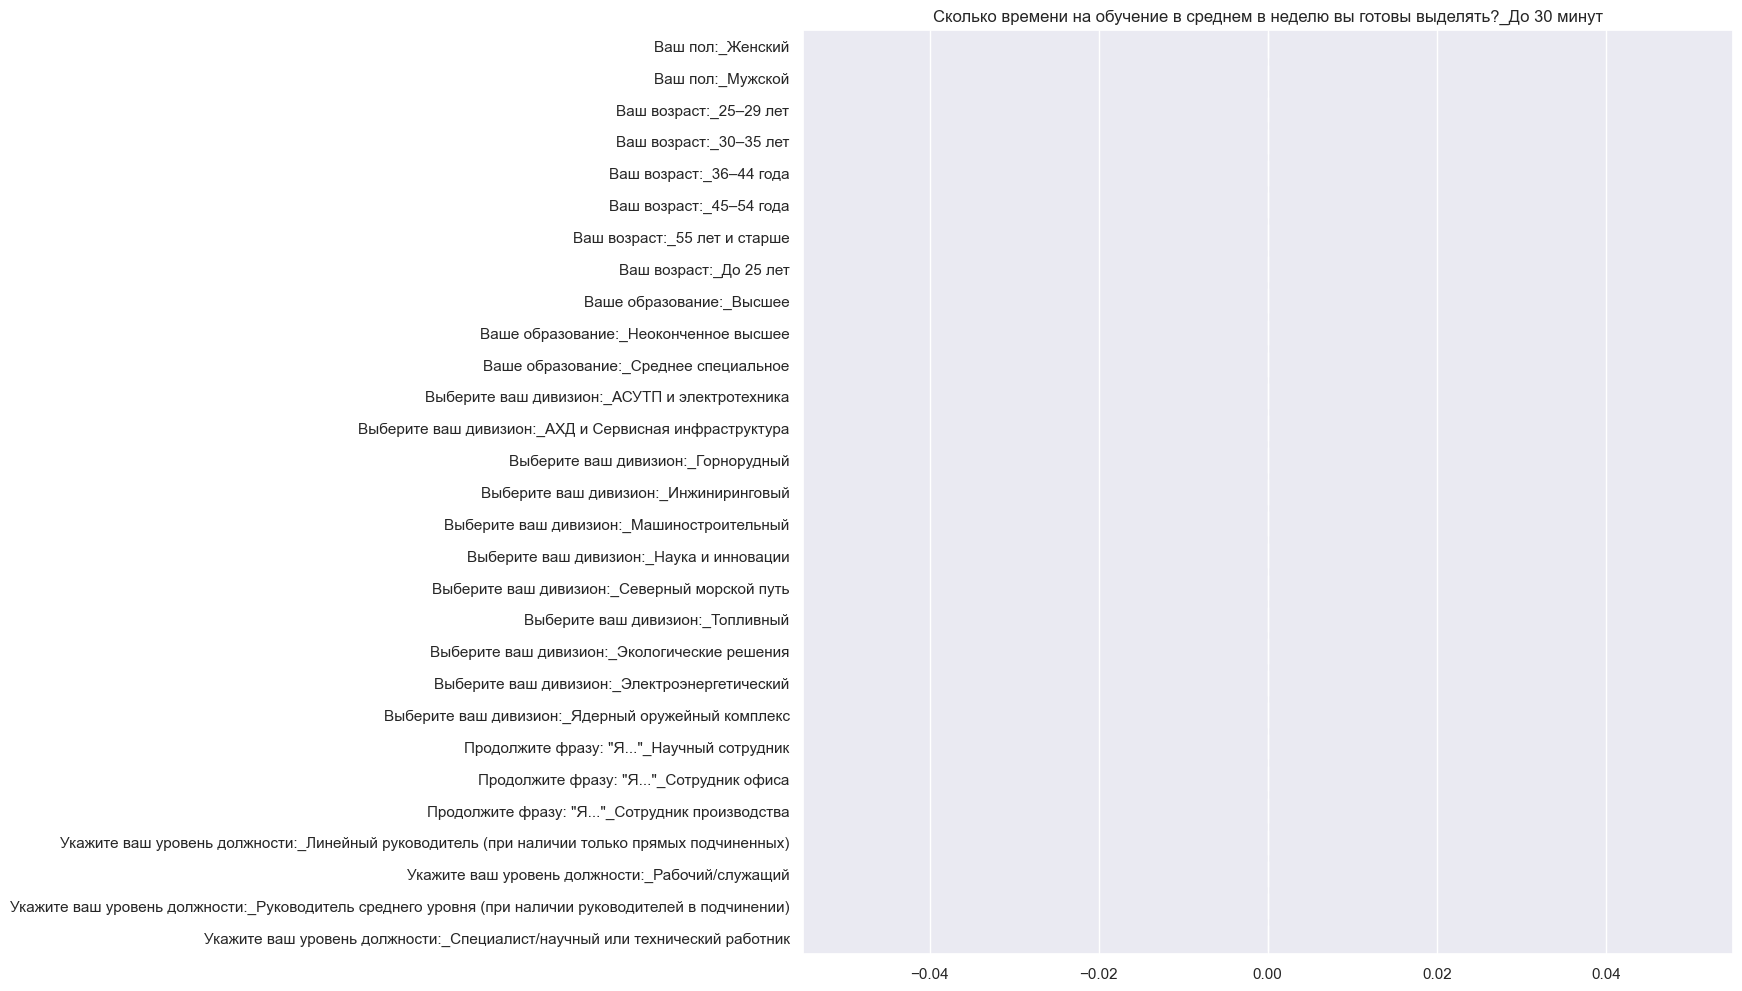

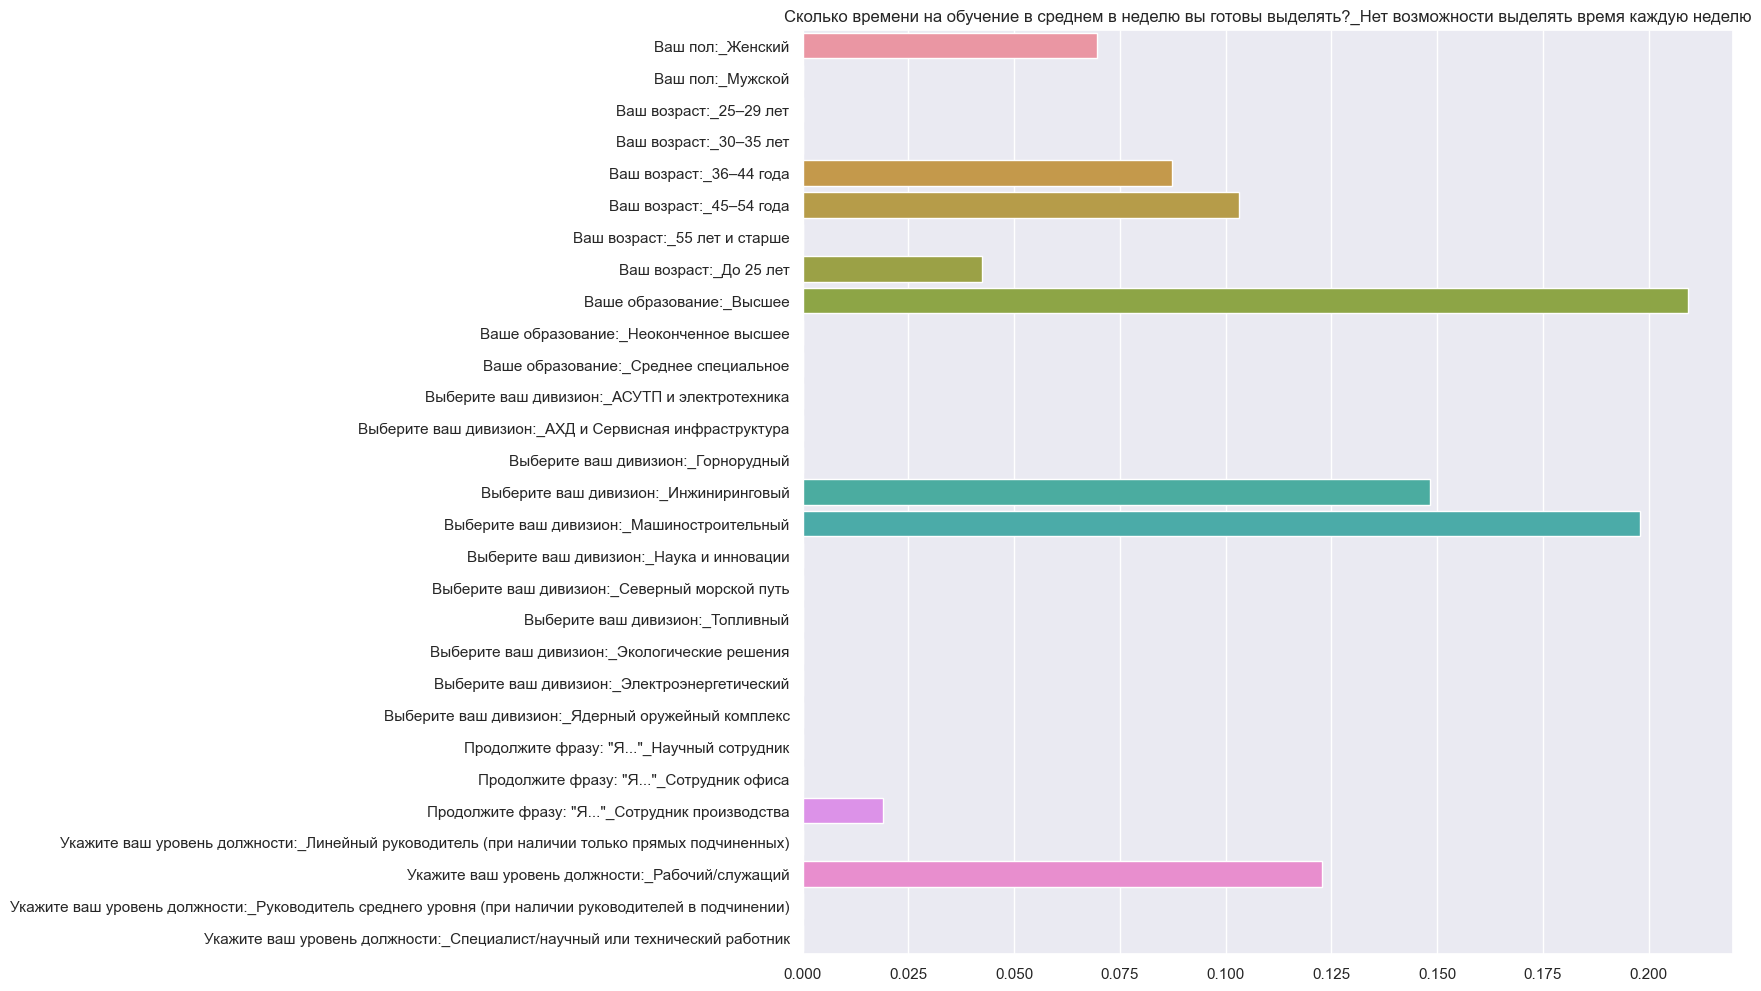

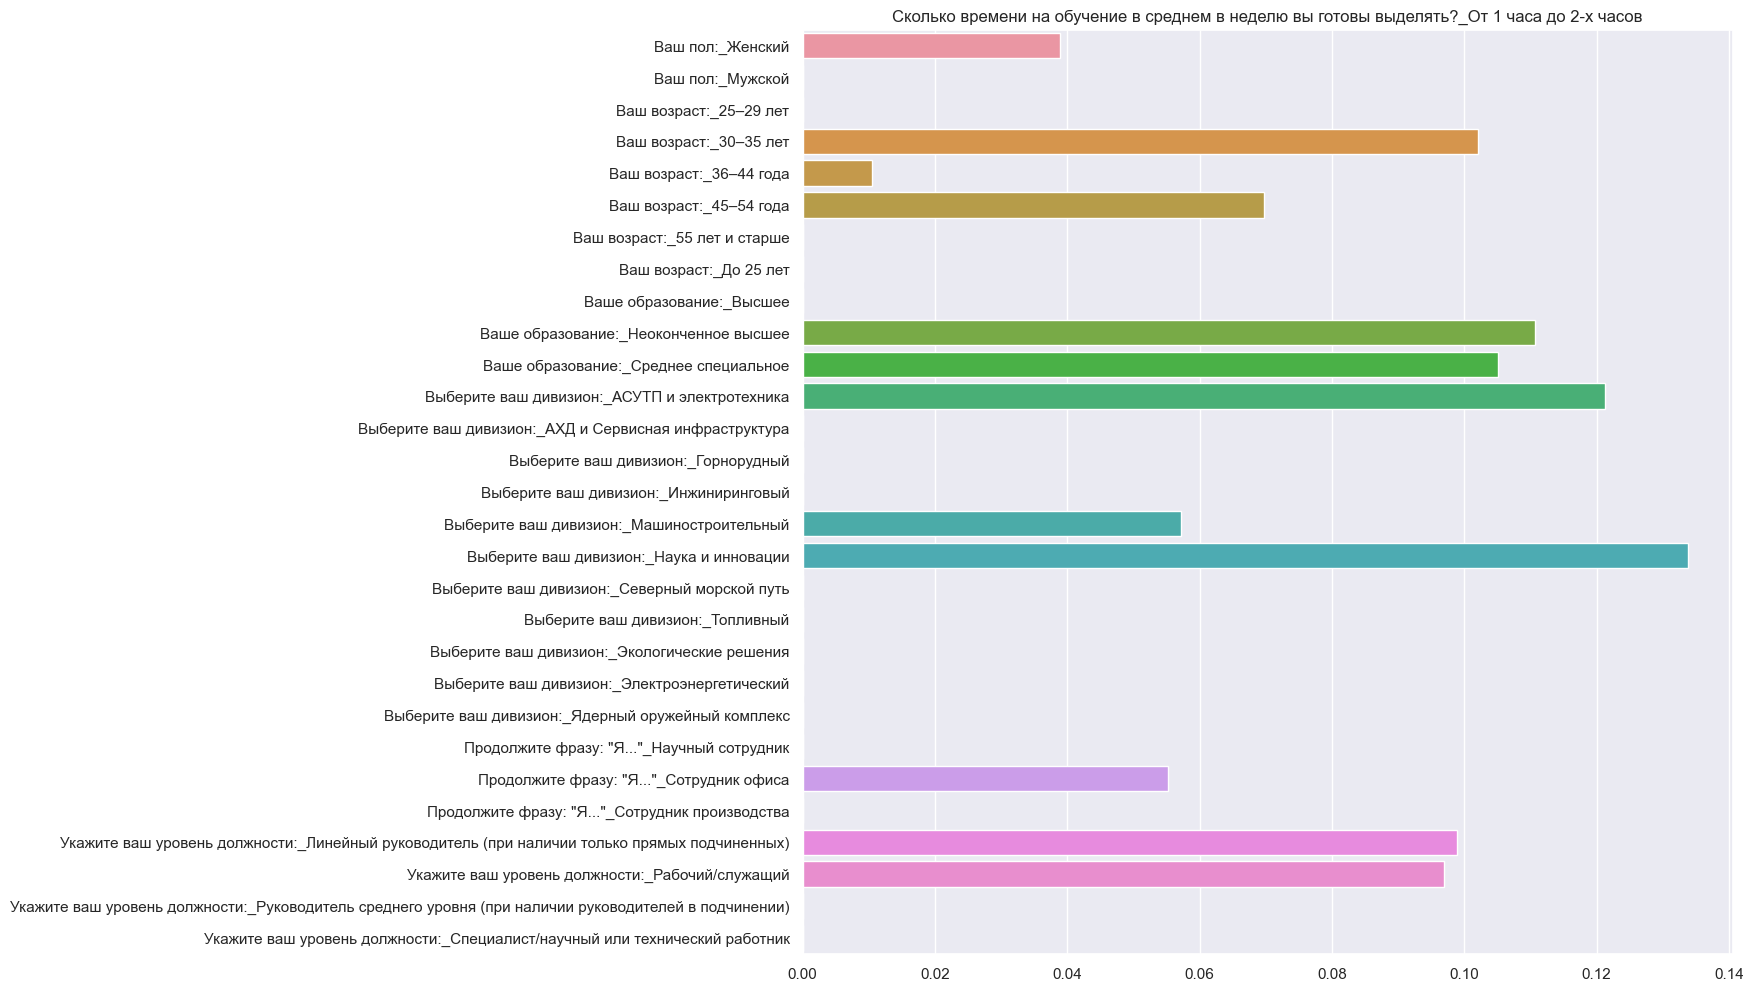

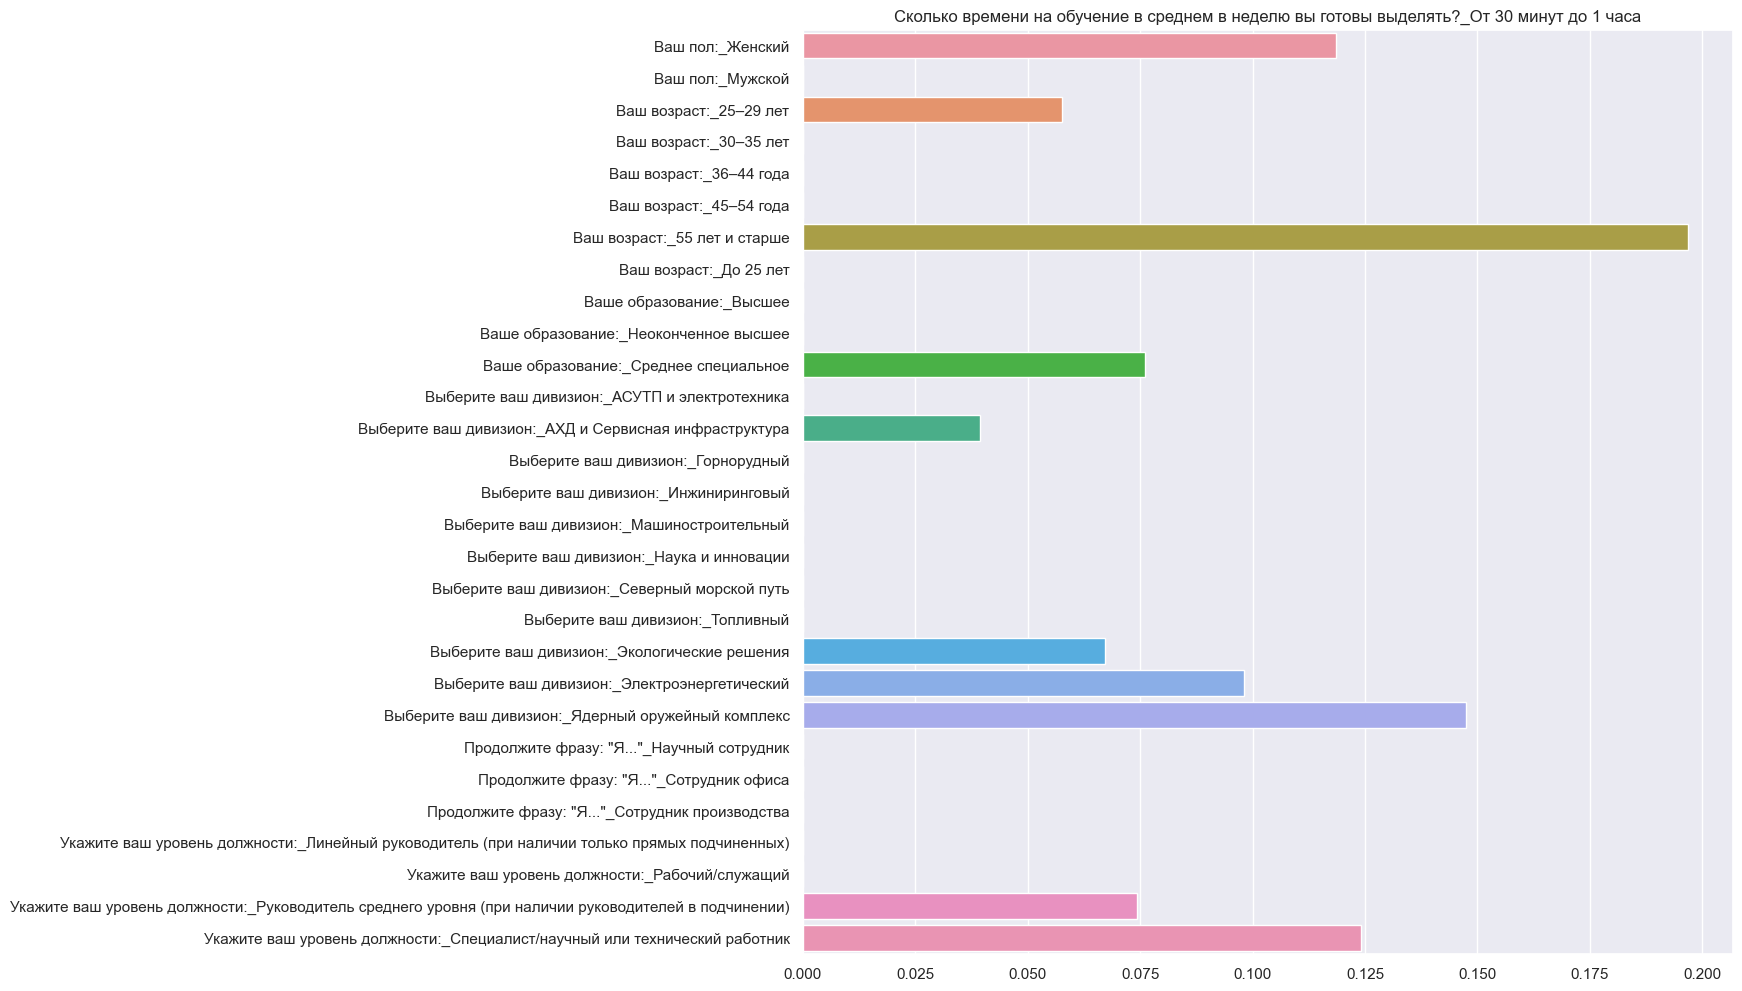

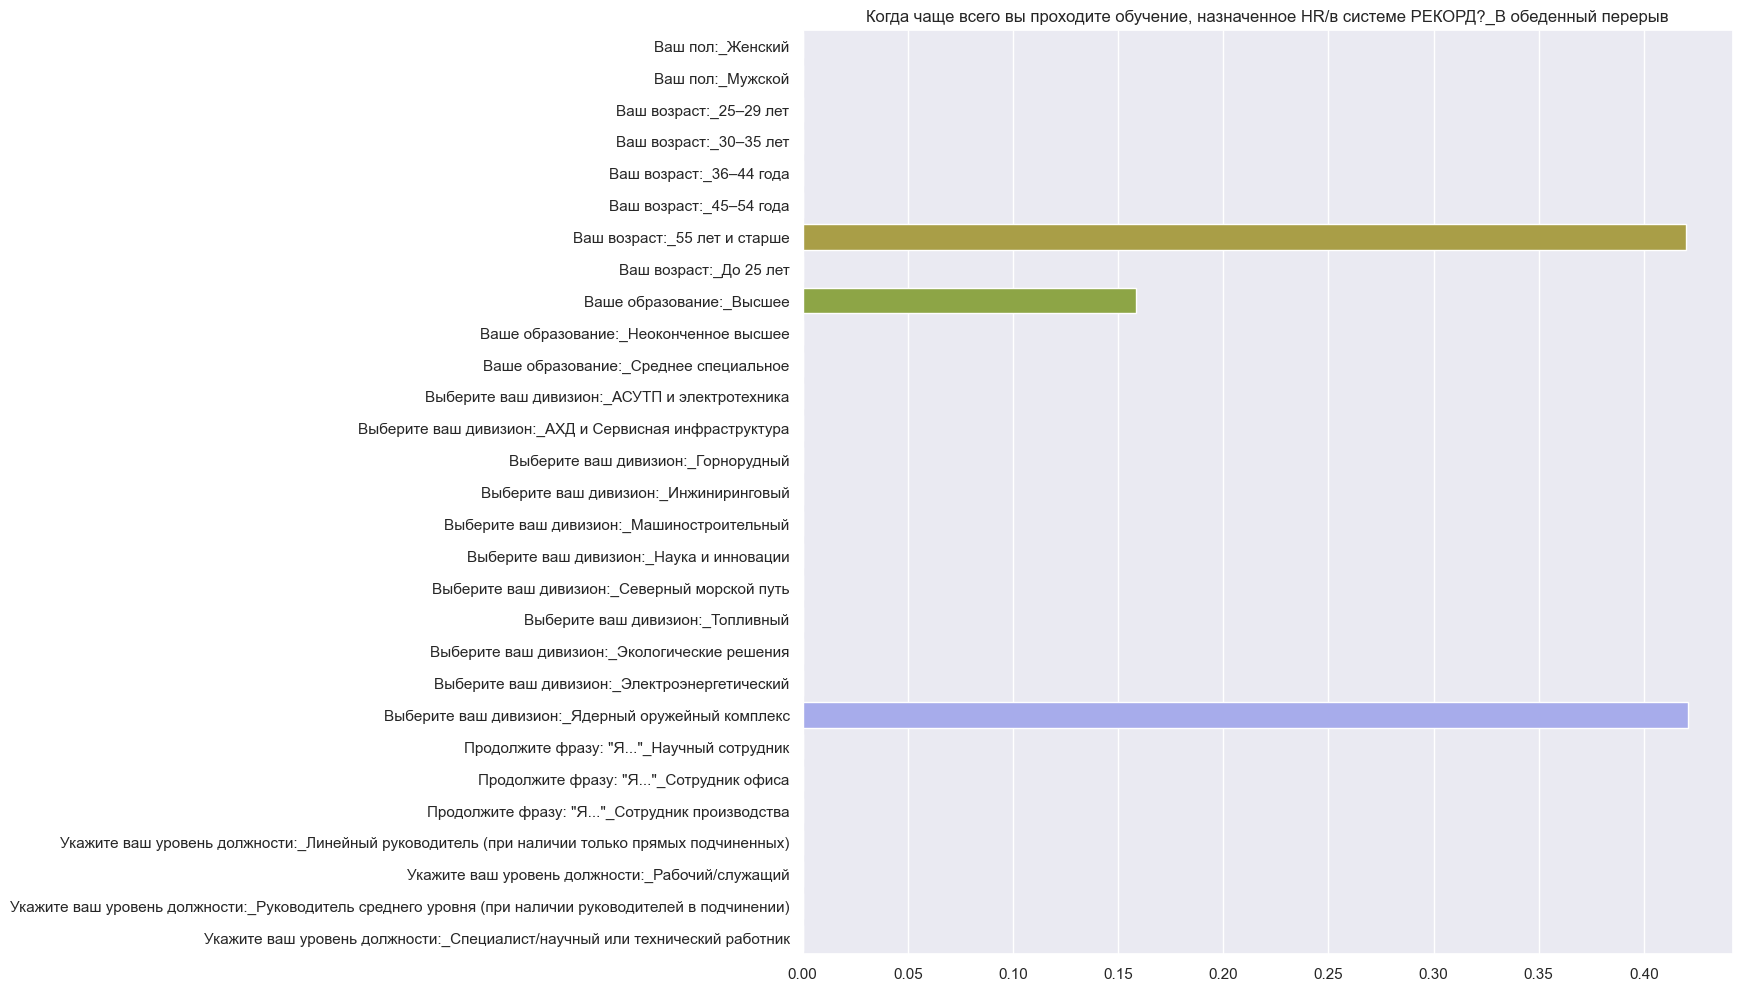

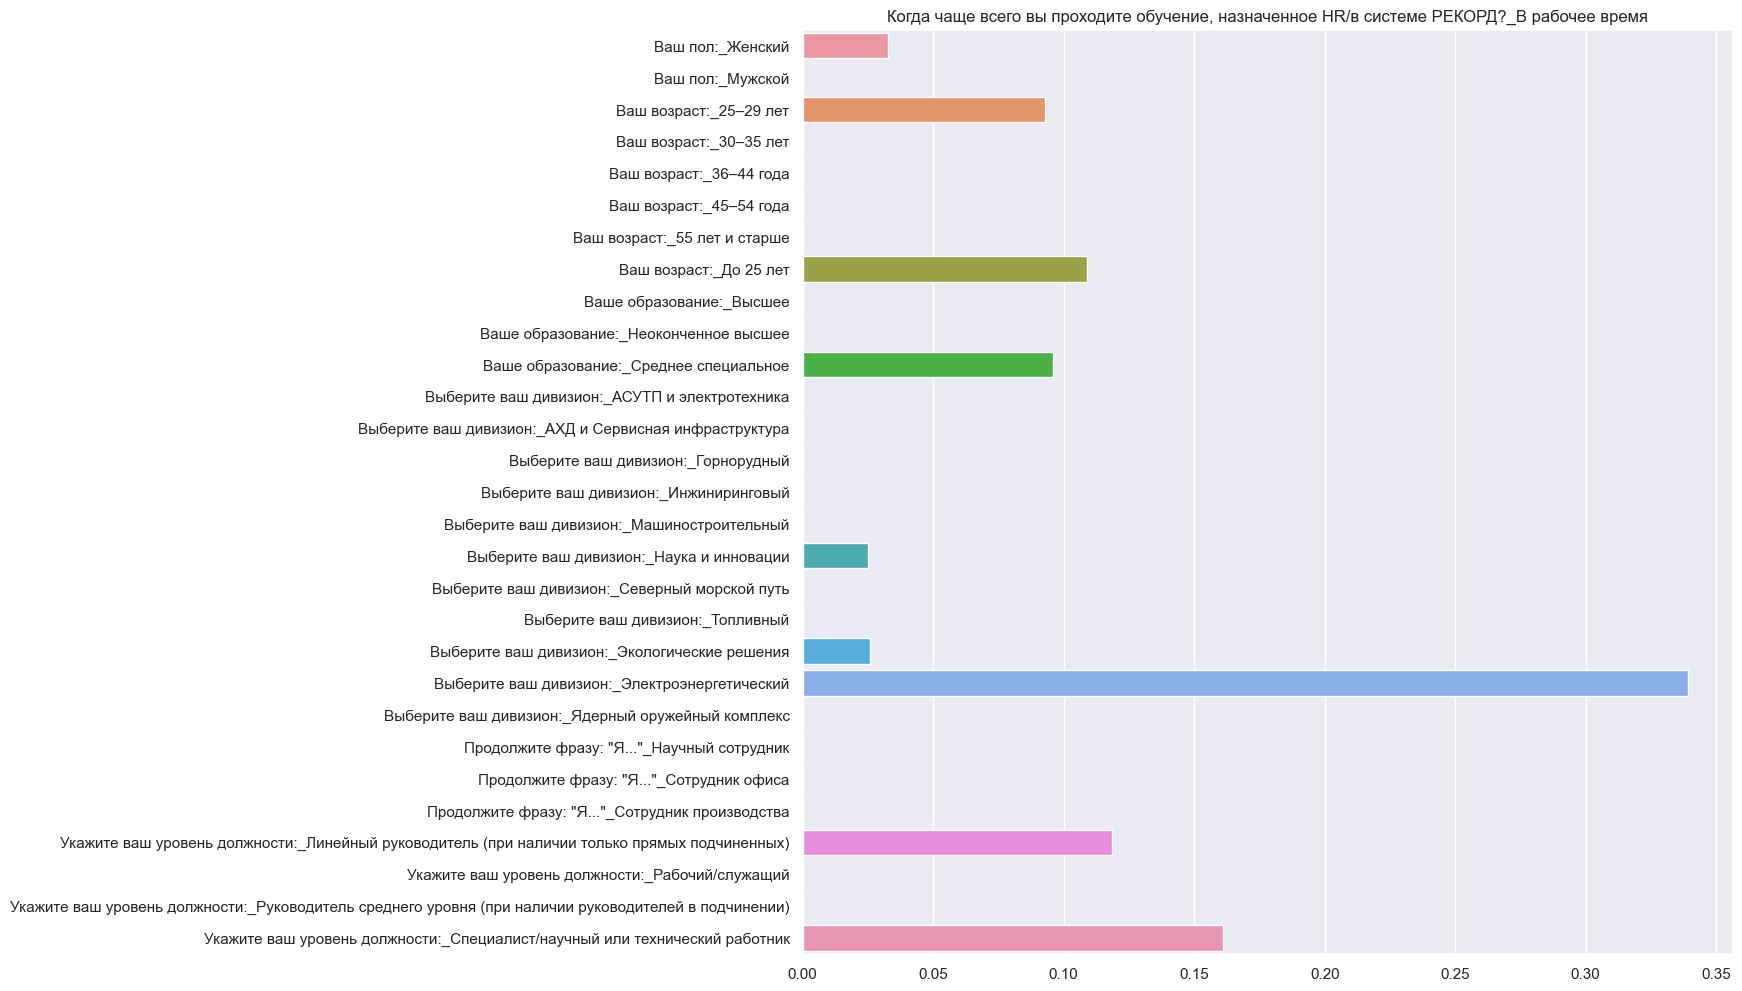

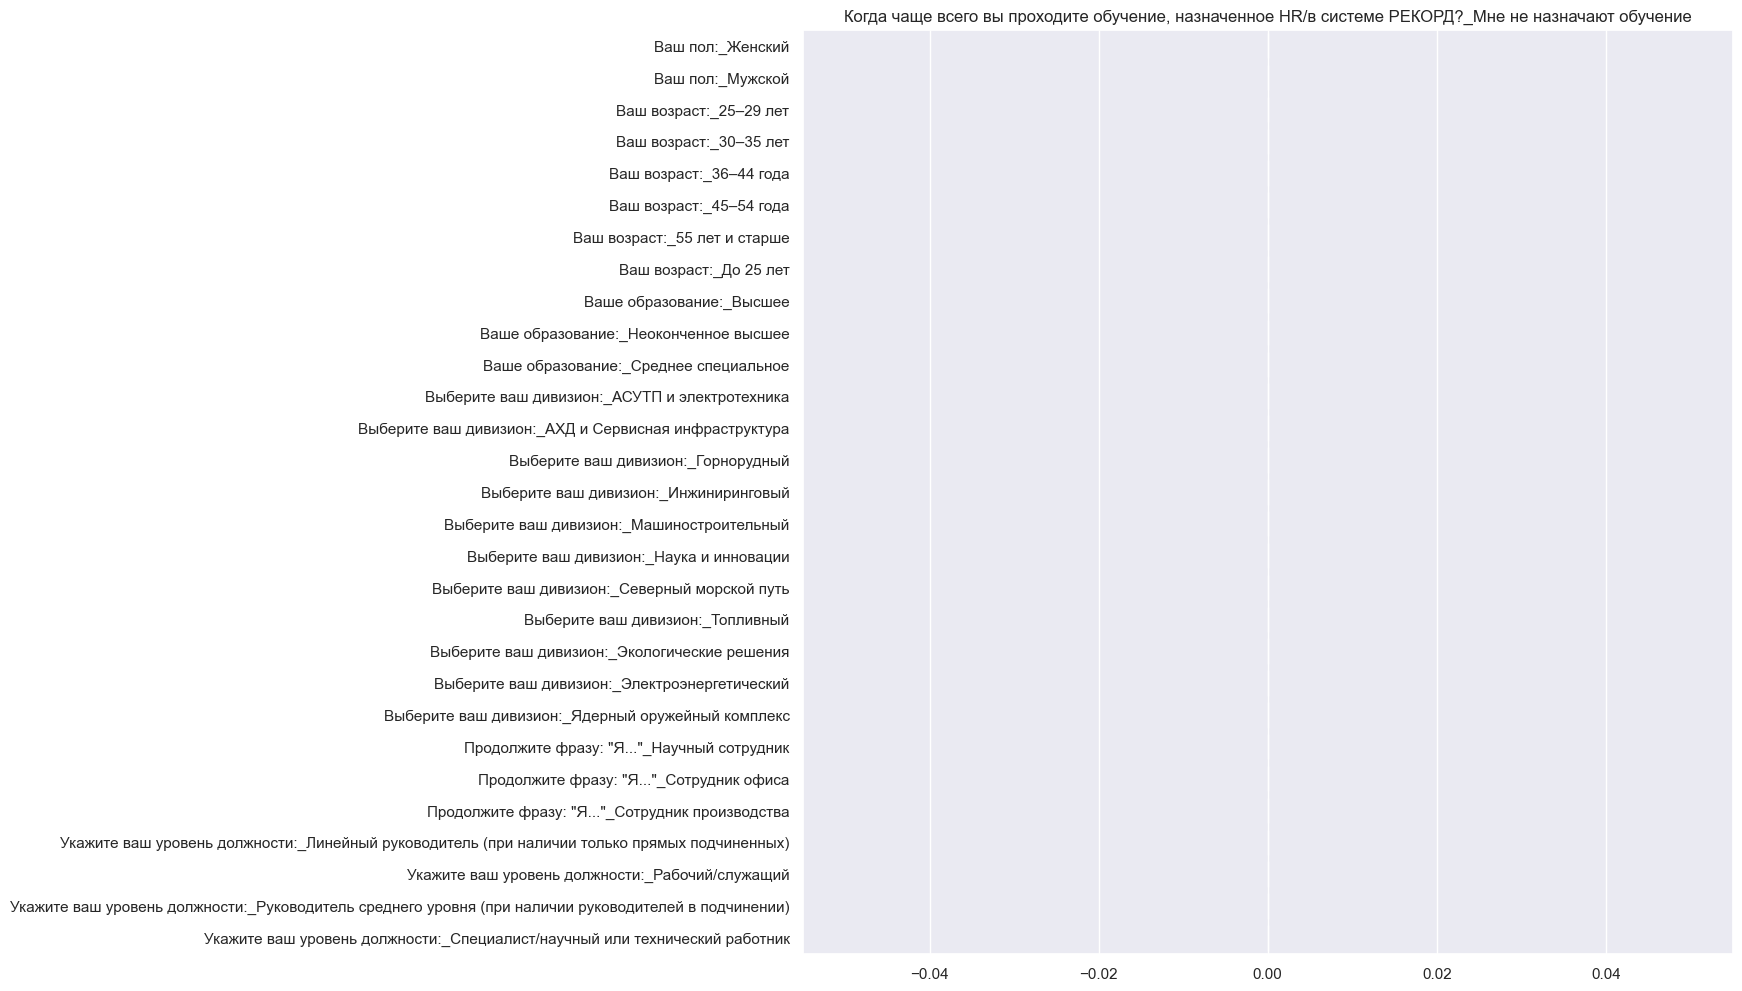

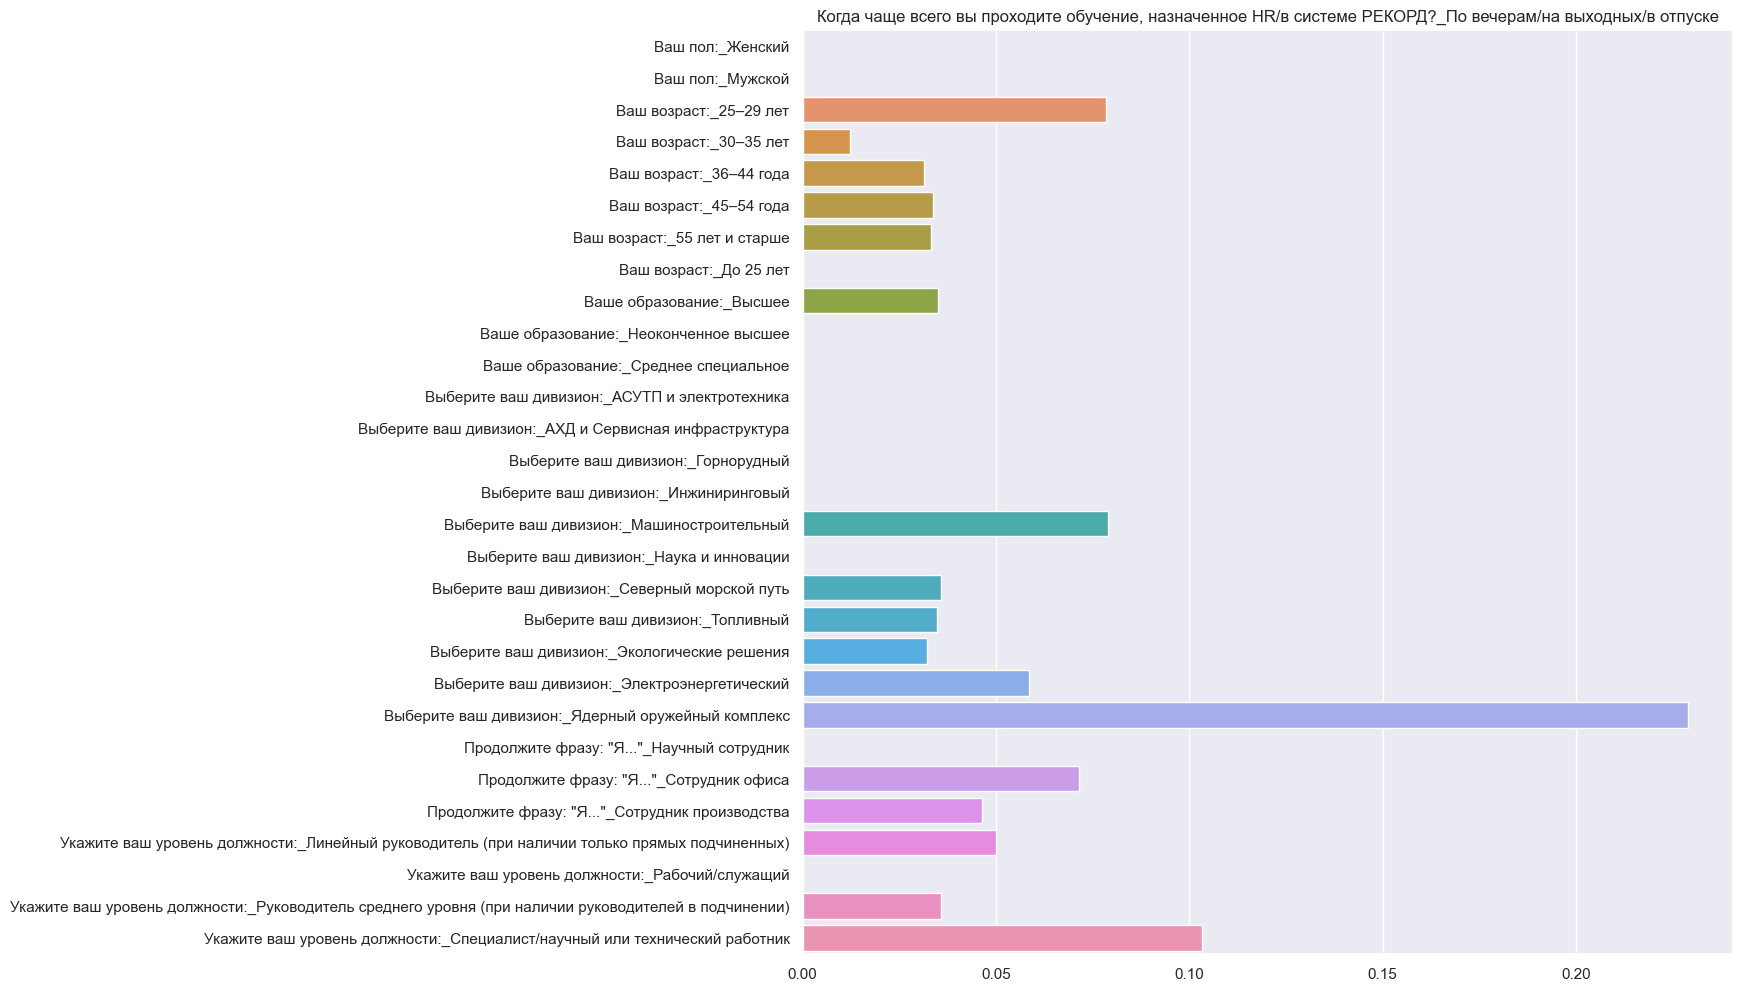

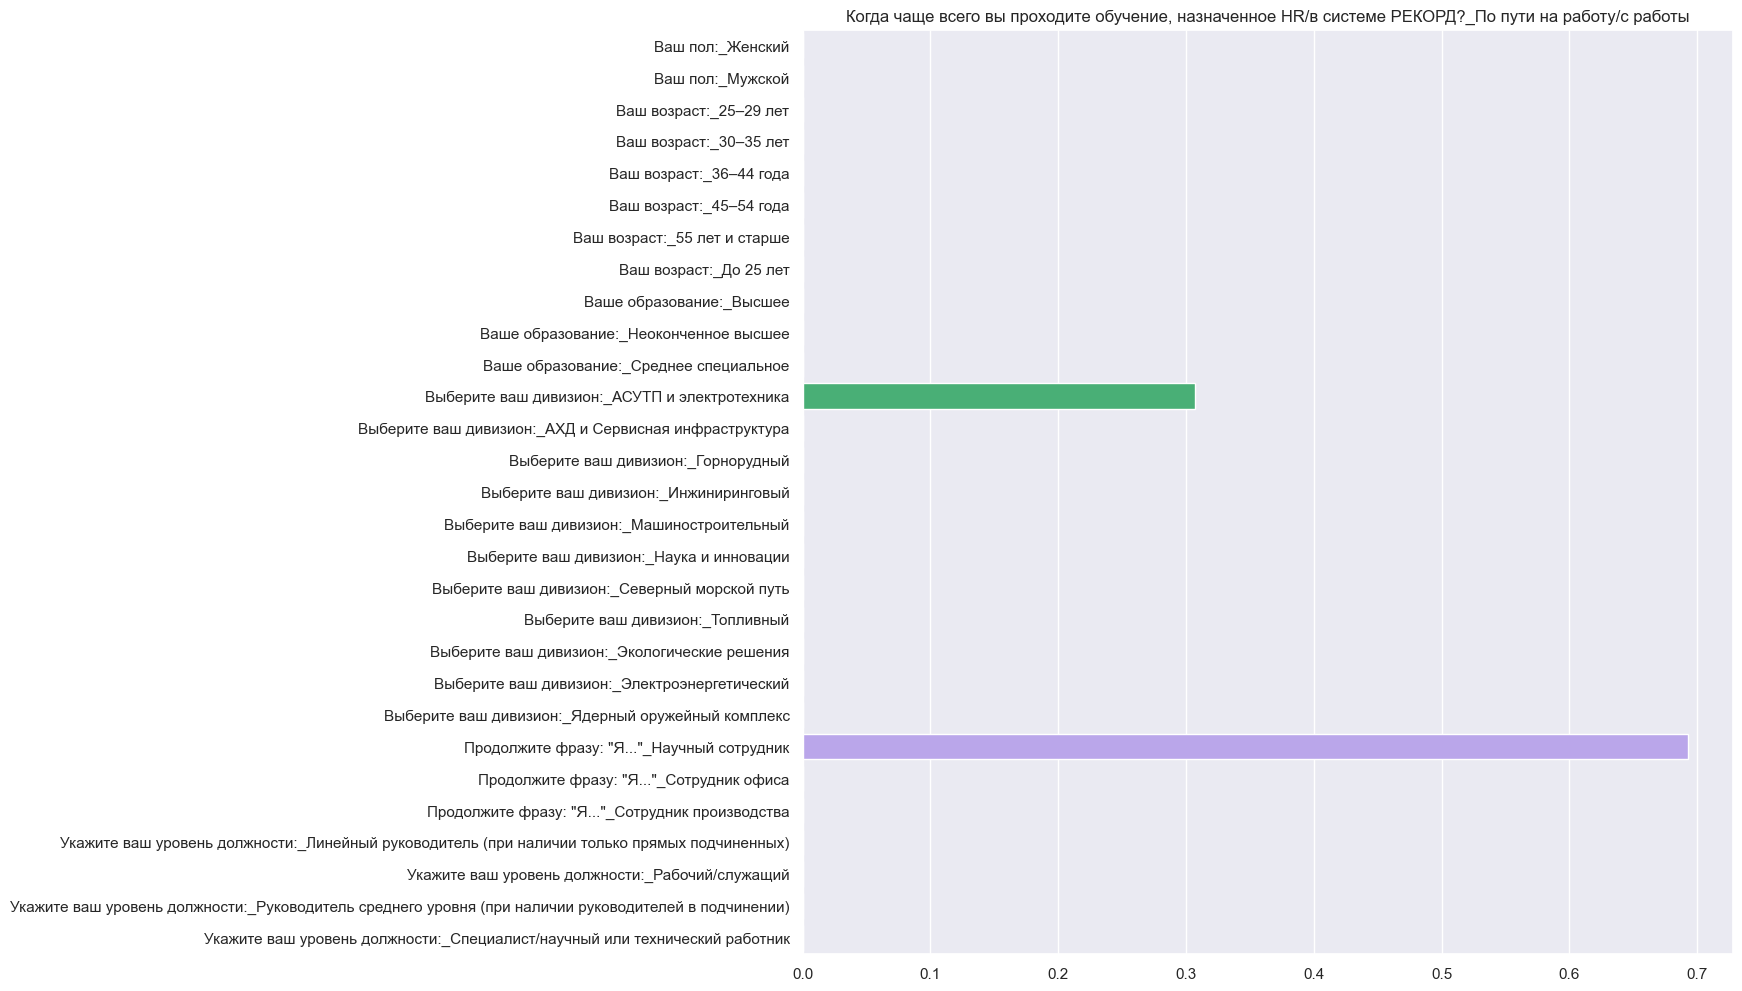

In [261]:
for i in range(len(Y.columns)):
    get_feature_importances_from_column(X, Y, i, plot_shap=False)

# Testing

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

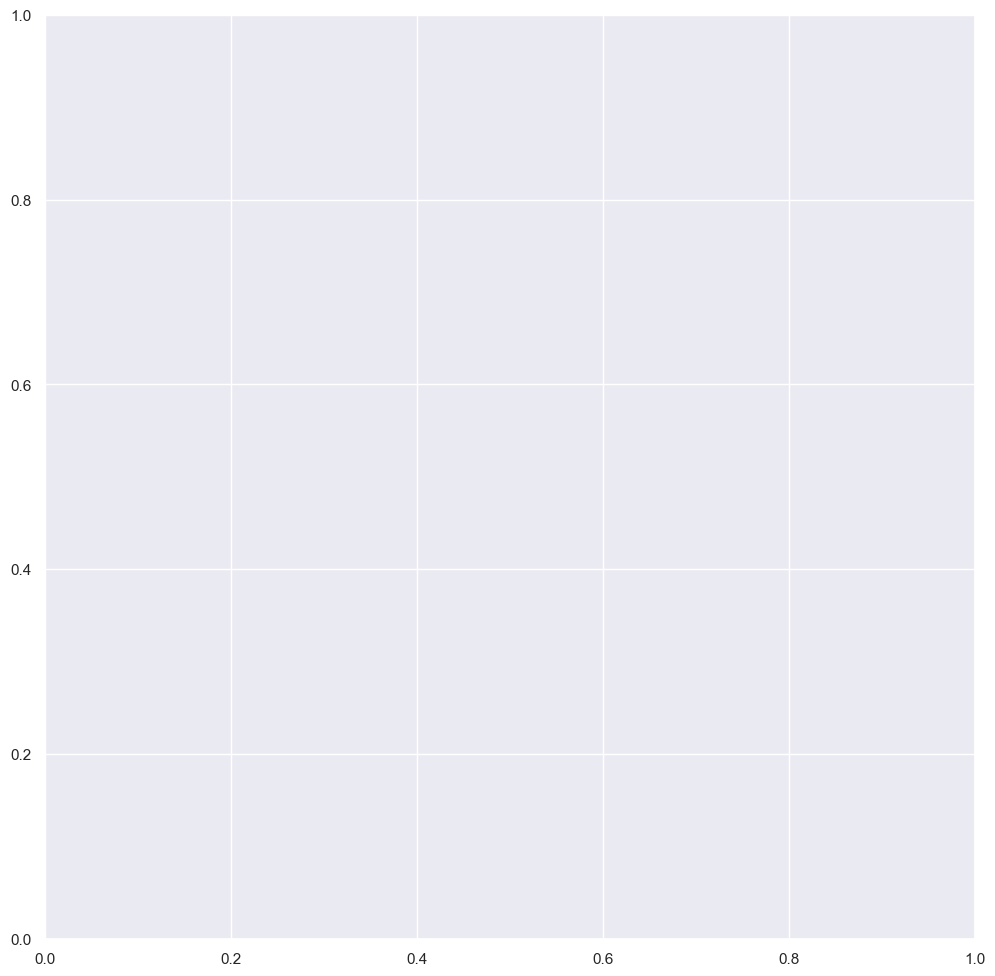

In [253]:
from xgboost import plot_tree

plot_tree(model)
plt.show()